In [1]:
import rpy2.robjects as robjects
import argparse
import os
import json
import warnings
import pandas as pd
import numpy as np
import time
import random
import collections
import copy

from op_main import OperatorNetInit
from train import train

warnings.filterwarnings(action='ignore')

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

In [3]:
print("#"*20," FIR-DKT START ", "#"*20)

num_partial_kc = 12
num_candidate_kc = 10
num_total_kc = 20
num_logs = 1000
target_err = 0.05

####################  FIR-DKT START  ####################


In [4]:
# 전체 세트에서 첫번째 subset 반환
def SelPartialKCs(json_path, data_path):
    sub_kcs = np.zeros(num_partial_kc)
    
    #json_path = './info_back.json'
    # 기존 json 파일 읽어오기
    with open(json_path, 'r') as file:
        data = json.load(file)

    # 데이터 수정
    data[0]['input_file_name'] = str(data_path)

    # 기존 json 파일 덮어쓰기
    with open(json_path, 'w', encoding='utf-8') as file:
        json.dump(data, file, indent="\t", ensure_ascii=False)

    # R 관계 분석 실행
    robjects.r.source('./20220731_RF_LASSO.R', encoding='utf-8')
    
    # 결과 파일 가져와서 정제하기
    subset_df = pd.read_csv('./OUT/relation.csv')
    
    all_kcs = list(subset_df['before'].unique())
    
    
    # sub_kcs 는 첫번째 원소는 before, 그 뒤는 모두 rank 순으로 after임.
    sub_kcs = {}
    for i in range(len(all_kcs)):
        cond = subset_df['before'] == all_kcs[0]
        after_kcs = list(subset_df[cond]['after'])

        sub_kcs[all_kcs[i]] = after_kcs
    
    
    # 후보로 뽑힌 12개 KC 반환
    return all_kcs, sub_kcs

In [5]:
def DoOperatorNet(data_path, n_epochs, kc_candidates, target_KC):
    # operator net을 위한 init
    model, n_epochs,train_loader,device,optimizer,valid_loader,n_items, items,acc_history, auc_history,f1_score_history = OperatorNetInit(data_path, n_epochs, kc_candidates, target_KC)

    print("="*20 + "TRAIN START" + "="*20)
    train(model, n_epochs,train_loader,device,optimizer,valid_loader,n_items,acc_history, auc_history,f1_score_history)
    print("="*20 + "TRAIN END" + "="*20)
    
    influence_mat = model.influence_matrix()
    influence_sum = []
    for i in range(n_items-1):
        influence_sum.append(sum(influence_mat[i]))
    
    rank = sorted(range(len(influence_sum)), key=lambda k: influence_sum[k], reverse=True)
    
#    print("Rank of KCs:")
#    print(items[rank])
#    for i in range(10):
#        print(items[rank.index(i)])

#    print(f1_score_history,auc_history, acc_history)
    
    ranked_kc_rel = items[rank]
    cur_err = max(auc_history)

    return ranked_kc_rel, cur_err

In [6]:
def SelectKCSet(KC_picking_tb, KC_candidates):
    pick_n = 5 - len(KC_candidates)
    m = pick_n - 1
    
    KC_picking_tb = dict(sorted(KC_picking_tb.items(), key=lambda x:x[1], reverse=False))
#    print("low : ", KC_picking_tb)
    low_set = []
    for key, value in KC_picking_tb.items():
        if key not in KC_candidates:
            low_set.append(key)
        if len(low_set) >= 3:
            break
    pick1 = random.sample(low_set, 1)
    KC_candidates.append(pick1)
    
    KC_picking_tb = dict(sorted(KC_picking_tb.items(), key=lambda x:x[1], reverse=True))
#    print("high : ", KC_picking_tb)
    high_set = []
    for key, value in KC_picking_tb.items():
        if key not in KC_candidates:
            high_set.append(key)
        if len(high_set) >= 4:
            break
    pick2 = random.sample(high_set, m)
    KC_candidates.append(pick2)
    
    # picking table update
    picks = pick1+pick2
    for i in range(len(picks)):
        KC_picking_tb[picks[i]] += 1 

    return KC_candidates, KC_picking_tb

In [7]:
json_path = './info_back.json'
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
data_path = "./data/my_algebra_picture3000_ordered_binary.csv"
n_epochs = 10

In [8]:
#GetRankedKCGraph(json_path, data_path)

In [9]:
# 결과 파일 가져와서 정제하기
subset_df = pd.read_csv('./OUT/relation.csv')

all_kcs = list(subset_df['before'].unique())


# sub_kcs 는 첫번째 원소는 before, 그 뒤는 모두 rank 순으로 after임.
sub_kcs = {}
for i in range(len(all_kcs)):
    cond = subset_df['before'] == all_kcs[i]
    after_kcs = list(subset_df[cond]['after'])

    sub_kcs[all_kcs[i]] = after_kcs

In [10]:
#result_df = pd.DataFrame(index=range(0), columns=['target','rel1','rel2','rel3','rel4','rel5','rel6','rel7','rel8','rel9','rel10','auc'])
result_df = pd.DataFrame(index=range(0), columns=['target','rel1','rel2','rel3','rel4','rel5','auc'])
result_df

,target,rel1,rel2,rel3,rel4,rel5,auc


In [11]:
#for kc_idx in range(num_total_kc):
for kc_idx in range(1):
    KC_picking_tb = dict(zip(sub_kcs[all_kcs[kc_idx]], [0]*12))

    cnt_best_kcs = 0
    best_auc = 0
    cur_err = 0
    best_kcs = []
    kc_candidates = random.sample(sub_kcs[all_kcs[kc_idx]], 5)
    
    ranked_kc_rel, cur_err = DoOperatorNet(data_path, n_epochs, kc_candidates, all_kcs[kc_idx])
    result_list = []
    result_list.append(all_kcs[kc_idx])
    result_list.extend(ranked_kc_rel)
    result_list.append(cur_err)
    result_df = result_df.append(pd.Series(result_list, index=result_df.columns), ignore_index=True)
    before_kcs = copy.deepcopy(ranked_kc_rel)

    for i in range(5): 
        
        # operator net(train)
        ranked_kc_rel, cur_err = DoOperatorNet(data_path, n_epochs, kc_candidates, all_kcs[kc_idx])

        result_list = []
        result_list.append(all_kcs[kc_idx])
        result_list.extend(ranked_kc_rel)
        result_list.append(cur_err)
        result_df = result_df.append(pd.Series(result_list, index=result_df.columns), ignore_index=True)
        
#        if i == 0:
#            before_kcs = []
#        else:
#            before_kcs = list(result_df.filter(regex='rel', axis=1).iloc[-2])
        
        # 결과에 대한 판단 시작
        # best set이 똑같은 게 3번 나오면 for문 종료
        if cnt_best_kcs >= 3:
            break
 
        # 현재와 best set이 같을 때
        if set(ranked_kc_rel) == set(best_kcs):
            print("같은 셋이 나왔음")
            cnt_best_kcs += 1
            before_kcs = copy.deepcopy(best_kcs)
            new_kcs = []
        # 현재 AUC가 직전 AUC보다 높다면
        elif cur_err >= result_df['auc'].iloc[-2]:
            print("다른 셋이면서 현재 AUC 직전 것보다 높음")
            # 현재 AUC가 best보다 높다면
            if cur_err > best_auc:
                print("다른 셋이면서 현재 AUC best보다 높음")
                cnt_best_kcs = 1
                before_kcs = copy.deepcopy(best_kcs)
                best_kcs = copy.deepcopy(ranked_kc_rel)
                new_kcs = list(set(ranked_kc_rel) - set(before_kcs))
        # 현재 AUC가 직전 AUC보다 낮다면
        else:
            print("현재 AUC 직전보다 낮음")
            new_kcs = []

        KC_candidates = []
        KC_candidates.extend(new_kcs)

        # picking table update
        for i in range(len(new_kcs)):
            KC_picking_tb[new_kcs[i]] += 1

        org_kcs = list(set.difference(set(ranked_kc_rel) - set(new_kcs)))
        # picking table update
        for i in range(len(org_kcs)):
            KC_picking_tb[org_kcs[i]] -= 1

        if len(KC_candidates) < 5:
            KC_candidates, KC_picking_tb = SelectKCSet(KC_picking_tb, KC_candidates)
        
        before_kcs = copy.deepcopy(ranked_kc_rel)
            

    with open('./OUT/0819KC_picking_tb.txt','w',encoding='UTF-8') as f:
        for code,name in KC_picking_tb.items():
            f.write(f'{code} : {name}\n')

====================DATA LOADING====================
size of train_data :  1800
size of valid_data :  900
size of test_data :  300
====================TRAIN PREPARE====================
device:  cuda
--------------------MODEL PREPARE--------------------
DKT(
  (rnn): LSTM(12, 50, num_layers=4, dropout=0.2)
  (layers): Sequential(
    (0): Linear(in_features=50, out_features=6, bias=True)
    (1): Sigmoid()
  )
)
====================TRAIN START====================
Epoch 1: f1_score=0.8960 auc_score=0.5396 highest_auc=0.0000
Epoch 2: f1_score=0.8960 auc_score=0.7461 highest_auc=0.5396
Epoch 3: f1_score=0.8960 auc_score=0.7458 highest_auc=0.7461
Epoch 4: f1_score=0.8960 auc_score=0.7533 highest_auc=0.7461
Epoch 5: f1_score=0.8960 auc_score=0.7532 highest_auc=0.7533
Epoch 6: f1_score=0.8960 auc_score=0.7532 highest_auc=0.7533
Epoch 7: f1_score=0.8960 auc_score=0.7523 highest_auc=0.7533
Epoch 8: f1_score=0.8960 auc_score=0.7550 highest_auc=0.7533
Epoch 9: f1_score=0.8960 auc_score=0.7550 hig

In [12]:
kc_candidates

['Enter.initial.in.diagram....given',
 'Draw.larger.bar....multiplication',
 'Enter.quantity.from.diagram.by.calculating',
 'Enter.smaller.inital.in.diagram....calculated',
 'Enter.total.in.diagram...calculated...multiplication']

In [13]:
KC_picking_tb

{'Enter.total.in.diagram...calculated...addition': 4,
 'Draw.larger.bar....addition.subtraction': 4,
 'Enter.subtracted.quantity.in.diagram': 4,
 'Enter.total.in.diagram...calculated...subtraction': 4,
 'Enter.larger.initial.in.diagram....given': 0,
 'Enter.smaller.initial.in.diagram....given': 0,
 'Draw.smaller.bar....multiplication': 0,
 'Enter.quantity.from.diagram.by.calculating': -1,
 'Enter.smaller.inital.in.diagram....calculated': -2,
 'Enter.total.in.diagram...calculated...multiplication': -2,
 'Draw.larger.bar....multiplication': -3,
 'Enter.initial.in.diagram....given': -3}

In [16]:
ranked_kc_rel

array(['Enter.smaller.inital.in.diagram....calculated',
       'Enter.subtracted.quantity.in.diagram',
       'Draw.larger.bar....multiplication',
       'Enter.quantity.from.diagram.by.calculating',
       'Enter.total.in.diagram...calculated...multiplication'],
      dtype=object)

In [17]:
best_kcs

['Draw.larger.bar....multiplication',
 'Enter.quantity.from.diagram.by.calculating',
 'Enter.total.in.diagram...calculated...multiplication',
 'Enter.smaller.inital.in.diagram....calculated',
 'Enter.subtracted.quantity.in.diagram']

In [109]:
cnt_best_kcs

0

In [110]:
result_df

,target,rel1,rel2,rel3,rel4,rel5,auc
0,Copy.initial.in.diagram,Draw.larger.bar....addition.subtraction,Enter.initial.in.diagram....given,Enter.smaller.initial.in.diagram....given,Enter.subtracted.quantity.in.diagram,Enter.total.in.diagram...calculated...subtraction,0.747639
1,Copy.initial.in.diagram,Draw.larger.bar....addition.subtraction,Enter.quantity.from.diagram.by.calculating,Enter.subtracted.quantity.in.diagram,Draw.smaller.bar....multiplication,Enter.larger.initial.in.diagram....given,0.665411
2,Copy.initial.in.diagram,Draw.larger.bar....addition.subtraction,Enter.quantity.from.diagram.by.calculating,Enter.subtracted.quantity.in.diagram,Draw.smaller.bar....multiplication,Enter.larger.initial.in.diagram....given,0.647111
3,Copy.initial.in.diagram,Draw.larger.bar....addition.subtraction,Enter.quantity.from.diagram.by.calculating,Draw.smaller.bar....multiplication,Enter.subtracted.quantity.in.diagram,Enter.larger.initial.in.diagram....given,0.670404
4,Copy.initial.in.diagram,Draw.larger.bar....addition.subtraction,Draw.smaller.bar....multiplication,Enter.subtracted.quantity.in.diagram,Enter.quantity.from.diagram.by.calculating,Enter.larger.initial.in.diagram....given,0.653183
5,Copy.initial.in.diagram,Draw.larger.bar....addition.subtraction,Enter.quantity.from.diagram.by.calculating,Enter.subtracted.quantity.in.diagram,Draw.smaller.bar....multiplication,Enter.larger.initial.in.diagram....given,0.662244
6,Copy.initial.in.diagram,Draw.larger.bar....addition.subtraction,Enter.quantity.from.diagram.by.calculating,Draw.smaller.bar....multiplication,Enter.subtracted.quantity.in.diagram,Enter.larger.initial.in.diagram....given,0.654447
7,Copy.initial.in.diagram,Draw.larger.bar....addition.subtraction,Enter.quantity.from.diagram.by.calculating,Enter.subtracted.quantity.in.diagram,Draw.smaller.bar....multiplication,Enter.larger.initial.in.diagram....given,0.658974
8,Copy.initial.in.diagram,Draw.larger.bar....addition.subtraction,Enter.quantity.from.diagram.by.calculating,Draw.smaller.bar....multiplication,Enter.subtracted.quantity.in.diagram,Enter.larger.initial.in.diagram....given,0.661051
9,Copy.initial.in.diagram,Draw.larger.bar....addition.subtraction,Enter.quantity.from.diagram.by.calculating,Enter.subtracted.quantity.in.diagram,Draw.smaller.bar....multiplication,Enter.larger.initial.in.diagram....given,0.659149


In [33]:
result_df.iloc[10:15,].filter(regex='rel', axis=1)

,rel1,rel2,rel3,rel4,rel5
10,Draw.larger.bar....addition.subtraction,Enter.total.in.diagram...calculated...addition,Enter.smaller.initial.in.diagram....given,Draw.larger.bar....multiplication,Enter.larger.initial.in.diagram....given
11,Draw.smaller.bar....multiplication,Enter.total.in.diagram...calculated...addition,Draw.larger.bar....multiplication,Draw.larger.bar....addition.subtraction,Enter.larger.initial.in.diagram....given
12,Draw.smaller.bar....multiplication,Enter.total.in.diagram...calculated...addition,Draw.larger.bar....multiplication,Enter.smaller.initial.in.diagram....given,Draw.larger.bar....addition.subtraction
13,Draw.smaller.bar....multiplication,Draw.larger.bar....multiplication,Enter.smaller.initial.in.diagram....given,Draw.larger.bar....addition.subtraction,Enter.larger.initial.in.diagram....given
14,Draw.smaller.bar....multiplication,Enter.total.in.diagram...calculated...addition,Draw.larger.bar....addition.subtraction,Enter.smaller.initial.in.diagram....given,Enter.larger.initial.in.diagram....given


In [48]:
a = []
a.extend(result_df.iloc[20:25,].filter(regex='rel', axis=1).values.tolist())
a = sum(a, [])

In [49]:
len(set(a))

6

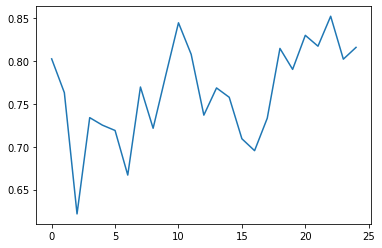

In [51]:
import matplotlib.pyplot as plt
result_df['auc'].plot()
plt.show()

In [27]:
result_df.to_csv('./OUT/FIR_Result_selector_test.csv', index=False)

In [18]:
! ls

 20220728_RF_LASSO.R   __pycache__	       merge_main_new_algo.ipynb
 20220731_RF_LASSO.R   data		       model.py
 20220802_RF_LASSO.R   data_loader.py	       op_main.py
 20220804_RF_LASSO.R   info_back.json	       result.png
'FIR DATA.ipynb'       kc_relations_time.csv   train.py
 KC_Ordering.json      merge_main.ipynb
 OUT		       merge_main.py


In [ ]:
! git clone 